#Radiometer Experiment 1 - Calibration and normal radiometer operation

## Experimental setup

![Lab Setup](https://lh5.googleusercontent.com/-MQnV1zYcQWA/VKmzjJYKqYI/AAAAAAAB84E/1qX4x5rKVAQ/w977-h733-no/20150104_154121.jpg)

Experiment 1 is used to help us establish that we can look at different physical temperatures that are calibrated to the radiometer.  For this experiment we use both the Software Defined Radio running GNURadio with the radiometer firmware and a square-law detector that is connected to a data aquisition unit.  The experiment uses a 50 ohm matched load that is attached to the radiometer.  This matched load is then submerged into three different baths, a Liquid Nitrogen at ~ 77 K, Ice bath at ~ 273.15 K and hot water water at 341.15 K.   

## Software Defined Radio setup
The Software Defined Radio uses a N200 SDR with GNURadio running a custom code for the radiometer.  This program includes a GUI that allows for us to monitor the radiometer as well as control many of the properties of the radiometer such as frequency, bandwidth and integration time.  
![GNURadio Program](https://lh6.googleusercontent.com/-8X3Tm3wyh-k/U-mZk_99UcI/AAAAAAAB5Vk/-Up_76efr7E/w1214-h759-no/Lab_0_Spectrum.png)

The program stores the data as a binary format which we can then load into a program such as Matlab or Python.  

## Square-law detector
The square-law detector is connected to a NI-USB6000 DAQ system.  This records the analog voltage sent from the square-law detector.  A LabView program then receives this data and stores the data in a ASCII CSV file.  

![GNURadio Program](https://lh5.googleusercontent.com/-sLn6266TiCs/U-mZpQ2LFfI/AAAAAAAB5Vs/eV8G_uUIQeU/w1402-h759-no/labviewx2_lab0.png)

It also allows us to monitor the data as well.  The square-law detector however does not have any other parameters we can set such as frequency.
- - -

The following code reads in the data recorded and then graphs the information

We begin with setting up our environment and importing needed libraries.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import numpy
import scipy.io as sio
import csv

Use this to set the filename for the data file and CSV Calibration file.

In [3]:
tpr = 'SDR_TPR_EXP1.dat'
calib = 'calib.csv'
x2_data = 'x2data_EXP1_ASCII.csv'

The following reads in the binary file produced by GNURadio.  This stores it into an array that Python can work with.

In [4]:
f = scipy.fromfile(open(tpr),dtype=scipy.float32)

Because of the valve function in GNURadio, there are zeros that get added to the file.  We want to trim out those zeros.

In [5]:
f = numpy.trim_zeros(f)

Create an index array for plotting.  Also, since we know the interval the data is taken, we can convert this to an actual time.

In [6]:
y = numpy.linspace(0,(len(f)*.5),numpy.size(f))

## Plot the data

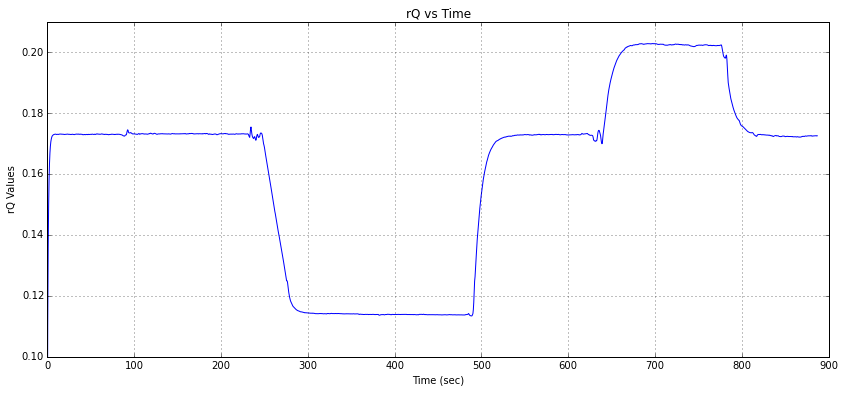

In [7]:
fig = plt.figure(figsize=(14,6), dpi=100)
plot(y,f)
xlabel('Time (sec)')
ylabel('rQ Values')
title('rQ vs Time')
axis([0, 900, .1, .21])
grid(True)

## Calibration

The rQ values are the raw values from the total power radiometer and are uncalibrated.  While the graph shows the change in the total power recorded and shows that the radiometer can detect changes in noise temperature, it has no other meaning than that.  What we want is to show what the total power is in relation to a noise temperature.  Since we have recorded the values of the rQ at fixed and known teperatures, we can create a calibration line and calibrate the radiometer.  For this experiment, we found that the following values matched our two known temperatures.

|rQ Value|X^2 Voltage|Temperature
|--------|-----------------------
|.1139   | 1.9846    |77 K
|.1730   | 2.1065    |271.65 K

We can now solve for y = mx + b since we have two equations and two unknowns.

To work with this, a calibration file is created.  This is a very simple CSV file that contains 3 values: The raw rQ value, the raw voltage from the square-law detector (discussed later) and the observed temperature.  The table above would then look like the following in the file.
```
.1139,1.9846,77
.1730,2.1065,271.65
```
- - -

It should be noted that from here on out we will just use the LN2 and and ice water bath for our two points.  Because the square-law detector and the SDR have different sensitivities, it will mean that there will be an error when it goes outside of the calibration points.  Multiple points could be used, but traditionally we calibrate a radiometer to just two known points.  

We need to read in the values from our CSV file that contains the values

In [8]:
read_csv = open(calib, 'rb')
csvread = csv.reader(read_csv)
rQ_values = []
temp_values = []
voltage = []

for row in csvread:
    rQ,volt,temp = row
    rQ_values.append(float(rQ))
    voltage.append(float(volt))
    temp_values.append(float(temp))
read_csv.close()

In [9]:
a = numpy.array([[rQ_values[0],1.0],[rQ_values[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [10]:
z = numpy.linalg.solve(a,b)
print z

[ 3293.57052091  -298.13767695]


Now we apply these values to the array that holds our raw rQ values

In [11]:
g = f*z[0]+z[1]

Now we can re-plot the graph but this time with the calibrated noise temperatures

[0, 900, 70, 390]

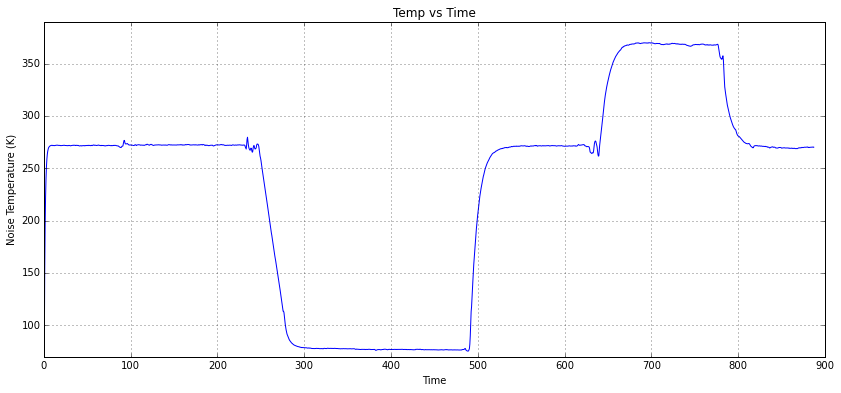

In [12]:
fig = plt.figure(figsize=(14,6), dpi=100)
plot(y,g)
xlabel('Time')
ylabel('Noise Temperature (K)')
title('Temp vs Time')
grid(True)
axis([0, 900, 70, 390])

- - -
# Square-law data

We now want to look at the data from the Square-Law detector to verify the operation of the SDR.  In the experiment that was conducted above, a power splitter was used to split the RF signal so that one went to the SDR and the other to a square-law detector (with a 3.1 dB loss though).  Therefore both data should be the same.  Let's read and then plot this data.

In [13]:
read_csv = open(x2_data, 'rb')
csvread = csv.reader(read_csv)
dummy = []
x2_voltage = []

for row in csvread:
    dummy,x2voltage = row    
    x2_voltage.append(float(x2voltage))
read_csv.close()

Like the SDR data, we want to have a time reference at the bottom.

In [14]:
w = numpy.linspace(0,(len(x2_voltage)*.01),numpy.size(x2_voltage))

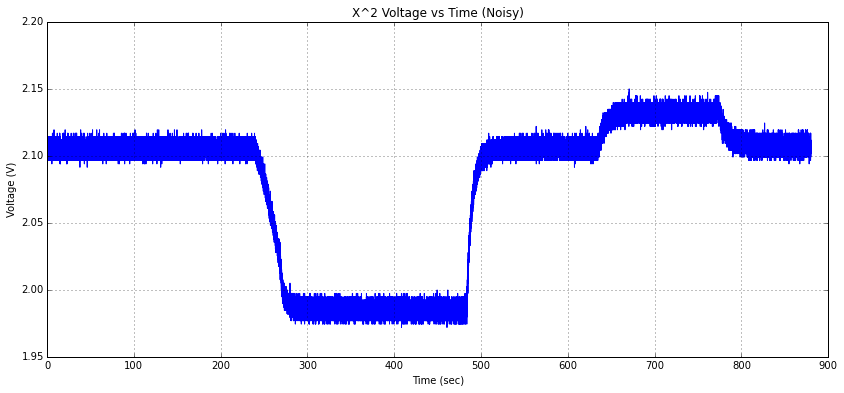

In [15]:
fig = plt.figure(figsize=(14,6), dpi=100)
plot(w,x2_voltage)
xlabel('Time (sec)')
ylabel('Voltage (V)')
title('X^2 Voltage vs Time (Noisy)')
grid(True)


The Square-law detector doesn't have a filter on it unlike the data we get from the SDR.  The GNURadio program takes the data and applies a Low Pass Filter to "clean up" the information.  We need to do the same with our Square-law data.

In [16]:
from scipy import signal
N=100
Fc=2000
Fs=1600
h=scipy.signal.firwin(numtaps=N, cutoff=40, nyq=Fs/2)
x2_filt=scipy.signal.lfilter(h,1.0,x2_voltage)

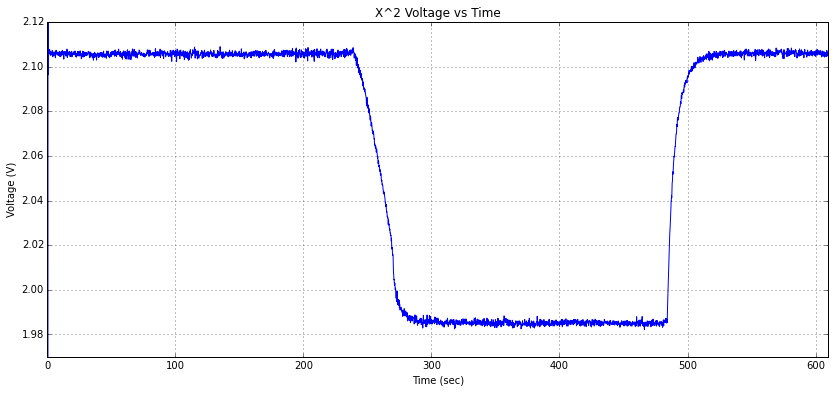

In [17]:
fig = plt.figure(figsize=(14,6), dpi=100)
plot(w,x2_filt)
xlabel('Time (sec)')
ylabel('Voltage (V)')
title('X^2 Voltage vs Time')
axis([0, 610, 1.97, 2.12])
grid(True)

Now we wish to calibrate this data as well.  We will use the same file and use the calibration points in that file.

In [18]:
a = numpy.array([[voltage[0],1.0],[voltage[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [19]:
z = numpy.linalg.solve(a,b)
print z

[ 1596.80114848 -3092.01147612]


In [20]:
x2_calib = x2_filt*z[0]+z[1]

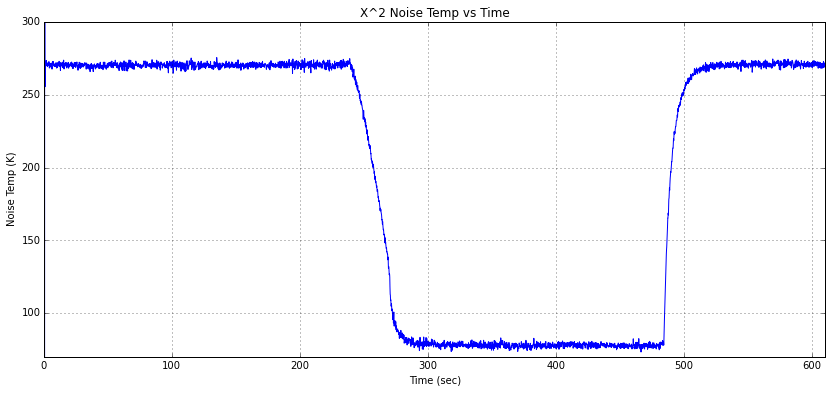

In [21]:
fig = plt.figure(figsize=(14,6), dpi=100)
plot(w,x2_calib)
xlabel('Time (sec)')
ylabel('Noise Temp (K)')
title('X^2 Noise Temp vs Time')
axis([0, 610, 70, 300])
grid(True)

This looks to be the same as our SDR graph, but let's overlay them to make sure

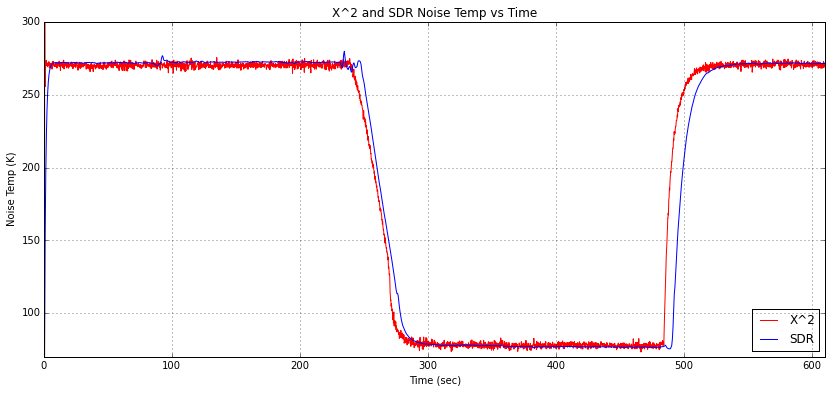

In [22]:
fig = plt.figure(figsize=(14,6), dpi=100)
plot(w,x2_calib,'r',label='X^2')
plot(y,g,'b',label='SDR')
xlabel('Time (sec)')
ylabel('Noise Temp (K)')
title('X^2 and SDR Noise Temp vs Time')
axis([0, 610, 70, 300])
grid(True)
legend(loc='lower right')

We have some timeshift due to two reasons.  One, the timing isn't always perfect when starting the collection of the two data sets.  And two, we get a timeshift from filtering the square-law data.  Another reason is that there the way the square-law detector and the SDR responses to changes is different.  I have attempted to match them up as best as I can, but some differences are to be expected.